#### COMP 215 - Project 03 (Final Exam)

# Sugarscape

#### Name: Ben Blair
#### Date: 21/04/2023

## Project Description:

In this project, a simple agent-based model is constructed based on Joshua Epstein and Robert Axtell's **Sugarscape**. The model was originally proposed in Epstein and Axtell's book, *Growing Artificial Societies*, and has since been used to support research in economics and social sciences.

## Credits:

This project was inspired by and adapted from Ch. 11 - Agent-based Models in [Think Complexity, 2nd Edition](https://thinkcomplex.com/).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT).

Previous COMP 215 example notebooks and course work as well as Powderflask's adaptation of Downey's Sugarscape model also provided guidance and useful code snippets.

## Import the necessary modules

In [1]:
%matplotlib inline

import time
from itertools import chain

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

import numpy as np

# Configure matplotlib's animation library to work in the browser.
mpl.rc('animation', html='jshtml')

In [2]:
# Initialize the default random number generator
rng = np.random.default_rng()

## Define some helper functions

The following functions were copied from Labs 7-10 and will help visualize what is going on in the Sugarscape.

In [3]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes (1s will be dark blue, 0s will be light blue). """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Define a color map to display the Sugarscape

The following color map was defined to aid visualization of the Sugarscape. It contains a discrete gradient of nine greyish-brown colors to represent varying levels of sugar as well as a single contrasting red color to represent the Agents that will inhabit the Sugarscape.

In [5]:
# Create an array of RGBA values where each row represents a color
ss_colors = np.ones((9, 4))
ss_colors[:, 0] = np.linspace(250/256, 115/256, 9)  # Set the R value
ss_colors[:, 1] = np.linspace(240/256, 105/256, 9)  # Set the G value
ss_colors[:, 2] = np.linspace(220/256,  85/256, 9)  # Set the B value

# Add a contrasting color to display the Agents
agent_color = np.array([200/256, 35/256, 35/256, 1])
ss_colors = np.vstack((ss_colors, agent_color))

# Create a matplotlib color map
ss_cmap = mpl.colors.ListedColormap(ss_colors)

## Build the Agents

Agents in the Sugarscape model have three defining attributes:

*   **Vision**: Agents can "see" nearby sugar and will move to the unoccupied cell containing the most sugar in each time step. However, the distance that each agent can see varies from 1 to 6 units and agents can only see sugar that lies in one of the four compass directions (i.e., North, East, South, West).
*   **Metabolism**: Agents consume a specific amount of sugar in each time step. However, the consumption of each agent varies from 1 to 4 units of sugar.
*   **Sugar**: Agents start with between 5 and 25 units of sugar and add the sugar they collect in each time step to this stockpile.

Agents take turns moving in a random sequence. If an Agent consumes more sugar than is stored in their stockpile, that agent "starves" and is removed from the Sugarscape.

In [6]:
class Agent:
    """ Represents an agent in the Sugarscape model. """

    def __init__(self, position=(0, 0), vision=(1, 6), metabolism=(1, 4), sugar=(5, 25), lifespan=(10000, 10000)):
        """
        Initializes an agent object.
        
        position:   tuple, the initial position of the agent
        vision:     tuple, min and max possible values for vision attribute
        metabolism: tuple, min and max possible values for metabolism attribute
        sugar:      tuple, min and max possible values for sugar attribute
        lifespan:   tuple, min and max possible values for lifespan attribute

        """
        
        self.position = position

        # Randomly assign attributes based on given min/max values
        self.vision = rng.integers(*vision, endpoint=True)
        self.metabolism = rng.integers(*metabolism, endpoint=True)
        self.sugar = rng.integers(*sugar, endpoint=True)
        self.lifespan = rng.integers(*lifespan, endpoint=True)

        self.age = 0

    
    @classmethod
    def get_agents(cls, n_agents, n, **params):
        """ Initializes n_agents at random positions in an n x n grid. """
        
        # Build a list of all possible positions in an n x n grid
        positions = [(i, j) for i in range(n) for j in range(n)]
        
        # Ensure the grid is big enough to hold all of the agents
        assert n_agents <= len(positions)

        # Randomize the possible positions and initialize the agents
        rng.shuffle(positions)
        agents = [cls(position=positions[i], **params) for i in range(n_agents)]

        return agents


    def get_target(self, world):
        """ Determine which cell to move to in the next time step. """

        def get_neighbours():
            """ Get grid positions of all visible cardinal neighbours. """
            
            # Get positions of North, East, South, West neighbours that are *distance* away
            def get_positions(row, col, distance):
                """ Get grid positions of neighbours that are *distance* away. """
                positions = [(row-distance, col), (row, col+distance), (row+distance, col), (row, col-distance)]
                rng.shuffle(positions)  # Randomize the order of the coordinates
                return positions
            
            # Get grid positions of all neighbours that are less than *self.vision* away from self
            positions = [get_positions(*self.position, distance) for distance in range(1, self.vision + 1)]
            neighbours = list(chain(*positions))  # Unpacks positions at each distance into one list
            
            return neighbours

        visible_positions = world.wrap_edges(get_neighbours())
        empty_positions = world.get_empty(visible_positions)

        if len(empty_positions) > 0:
            index = np.argmax(world.get_sugar(empty_positions))
            target = empty_positions[index]
        else:
            target = self.position
        
        return target


    def step(self, world):
        """ Moves the agent forward one time step. """

        # Locate and move to the neighbouring cell with the most sugar
        self.position = self.get_target(world)

        # Harvest and consume sugar
        self.sugar += world.harvest(self.position) - self.metabolism

        # Increment the agent's age
        self.age += 1


    def is_starving(self):
        """ Check if the agent has consumed more sugar than available. """
        return self.sugar < 0


    def is_old(self):
        """ Check if the agent has exceeded its lifespan. """
        return self.age > self.lifespan

### Testing the Agent Class

In [7]:
# Test the ability to assign a lifespan (or not)
immortal_agent = Agent()
print(vars(immortal_agent))
mortal_agent = Agent(lifespan=(65, 100))
print(vars(mortal_agent))

# Test the is_starving() and is_old() methods
assert not (mortal_agent.is_starving() and mortal_agent.is_old())

mortal_agent.sugar = -1
assert mortal_agent.is_starving()

mortal_agent.age = mortal_agent.lifespan + 1
assert mortal_agent.is_starving()

{'position': (0, 0), 'vision': 4, 'metabolism': 3, 'sugar': 19, 'lifespan': 10000, 'age': 0}
{'position': (0, 0), 'vision': 1, 'metabolism': 3, 'sugar': 19, 'lifespan': 76, 'age': 0}


In [8]:
# Test the factory method to initialize n agents
agents = Agent.get_agents(50, 10, sugar=(15, 15), lifespan=(65, 100))

# Ensure that all of the agents are positioned within the grid
for agent in agents:
    x, y = agent.position
    assert 0 <= x < 10 and 0 <= y < 10

# Print the attributes of the first 5 agents
for i in range(5):
    print(vars(agents[i]))

{'position': (3, 3), 'vision': 5, 'metabolism': 4, 'sugar': 15, 'lifespan': 72, 'age': 0}
{'position': (5, 2), 'vision': 5, 'metabolism': 3, 'sugar': 15, 'lifespan': 73, 'age': 0}
{'position': (5, 8), 'vision': 3, 'metabolism': 2, 'sugar': 15, 'lifespan': 90, 'age': 0}
{'position': (0, 2), 'vision': 5, 'metabolism': 1, 'sugar': 15, 'lifespan': 94, 'age': 0}
{'position': (7, 6), 'vision': 1, 'metabolism': 1, 'sugar': 15, 'lifespan': 71, 'age': 0}


## Build the Sugarscape

In the original Sugarscape model, there were two "mountains" of sugar located in the bottom-left and top-right corners of the environment.

These mountains can be created by assigning a maximum sugar capacity to each cell in a 2D grid. The mountain peaks will have the highest sugar capacity and capacity will decrease in concentric rings as the distance from the peak increases.

The first step in building the Sugarscape environment is to define a function that returns the sugar capacity for each cell in an n x n grid. NumPy's built-in `np.indices`, `np.hypot`, and `np.digitize` functions provide one solution to this problem.

In [9]:
def get_distances(cell, n):
    """ Compute the distance between the reference cell and all other cells in an n x n grid. """

    # Store row, col indix for reference cell
    ref_row, ref_col = cell

    # Get row, col indices for all cells in grid
    row_indices, col_indices = np.indices((n, n))

    # Compute distance between reference cell and all other cells in grid
    distances = np.hypot(row_indices-ref_row, col_indices-ref_col)

    return distances

distances = get_distances((3, 3), 7)
print(distances.astype(int))

[[4 3 3 3 3 3 4]
 [3 2 2 2 2 2 3]
 [3 2 1 1 1 2 3]
 [3 2 1 0 1 2 3]
 [3 2 1 1 1 2 3]
 [3 2 2 2 2 2 3]
 [4 3 3 3 3 3 4]]


In the `get_distances` function above, `np.indices` returns all row and column indices in the specified grid size. Then `np.hypot` calculates the distance (with help from everyone's favourite Pythagoras) between the specified reference cell and every other cell in the grid and returns an array containing the results.

When the resulting array of distances is printed (as integers), the numbers resemble more of a crater than a mountain but that can be fixed with `np.digitize`... 

In [10]:
bins = [3, 2, 1, 0]

sugar_caps = np.digitize(distances, bins)
print(sugar_caps)

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 2 2 2 1 0]
 [0 1 2 3 2 1 0]
 [0 1 2 2 2 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0]]


In the above code, `np.digitize` returns the index for the bin that contains each distance value in the resulting distances array. Note that the bins have been defined so that a distance value, $d$, maps to an index of:

*   0 if 3 < $d$
*   1 if 2 <= $d$ < 3
*   2 if 1 <= $d$ < 2
*   3 if 0 <= $d$ < 1

And now the resulting array resembles a mountain, where the value in each cell represents that cell's sugar capacity.

The above code can now be packaged into a function that returns the sugar capacity of each cell in an n x n grid with two sugar mountains...

In [11]:
def get_capacities(n):
    """ Compute the sugar capacities for all cells in an n x n grid. """

    # Get the position of each sugar peak
    row_1 = col_2 = (2/3) * n
    col_1 = row_2 = (1/3) * n

    def get_distances(cell, n):
        """ Compute the distance between the reference cell and all other cells in an n x n grid. """

        # Store row, col indix for reference cell
        ref_row, ref_col = cell

        # Get row, col indices for all cells in grid
        row_indices, col_indices = np.indices((n, n))  

        # Compute distance between reference cell and all other cells in grid
        distances = np.hypot(row_indices-ref_row, col_indices-ref_col)

        return distances

    def get_bins(dists):
        """ Compute the set of bins based on the provided distances array. """
        
        max_dist = np.amax(dists)   # Get max distance from dists array
        max_bin = (2/3) * max_dist  # Compute max bin size

        # Generate four evenly-spaced bins decreasing from max_bin
        bins = np.linspace(max_bin, 0, num=4, endpoint=False, dtype=int)

        return bins

    # Compute the distances
    dists_1 = get_distances((row_1, col_1), n)  # Compute distances from Peak 1
    dists_2 = get_distances((row_2, col_2), n)  # Compute distances from Peak 2
    distances = np.minimum(dists_1, dists_2)    # Keep only the min. distance for each cell

    # Compute the appropriate bins
    bins = get_bins(distances)
    
    # Digitize the distances according to the bins
    sugar_caps = np.digitize(distances, bins)

    return sugar_caps

In [12]:
sugar_caps = get_capacities(18)
print(sugar_caps)

[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 1]
 [0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 2 2 2]
 [0 0 0 0 0 1 1 2 2 3 3 3 3 3 3 3 2 2]
 [0 0 0 1 1 1 1 2 2 3 3 4 4 4 3 3 2 2]
 [0 1 1 1 1 1 1 2 2 3 3 4 4 4 3 3 2 2]
 [1 1 1 2 2 2 2 2 2 3 3 4 4 4 3 3 2 2]
 [1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 2 2]
 [1 2 2 2 3 3 3 3 3 2 3 3 3 3 3 2 2 2]
 [1 2 2 3 3 3 3 3 3 3 2 2 2 2 2 2 2 1]
 [1 2 2 3 3 4 4 4 3 3 2 2 2 2 2 2 1 1]
 [1 2 2 3 3 4 4 4 3 3 2 2 1 1 1 1 1 1]
 [1 2 2 3 3 4 4 4 3 3 2 2 1 1 1 1 0 0]
 [1 2 2 3 3 3 3 3 3 3 2 2 1 1 0 0 0 0]
 [1 2 2 2 3 3 3 3 3 2 2 2 1 1 0 0 0 0]
 [1 1 2 2 2 2 2 2 2 2 2 1 1 0 0 0 0 0]
 [1 1 1 2 2 2 2 2 2 2 1 1 1 0 0 0 0 0]]


The `get_capacities` function returns an array of sugar capacities for a landscape featuring two sugar mountains. Note that the `get_distances` function from earlier has been nested within the `get_capacities` function and a new `get_bins` function was defined to simplify the task of choosing the appropriate bins denominations for any given grid size.

### Constructing the Sugarscape class

The next step in building the Sugarscape model is to construct a Sugarscape class that will represent the world that the agents inhabitat.

The Sugarscape will have four primary attributes:

*   **Agents**: A list of Agent objects living in the Sugarscape.
*   **State**: The sugar contained in each cell at the current timestep.
*   **Capacity**: The maximum sugar capacity of each cell in the Sugarscape.
*   **Growth Rate**: The rate at which sugar replenishes.

The class will also define some methods to allow Agents to "see" and harvest the sugar in each cell.

In [13]:
class Sugarscape:
    """ Represents a world in the Sugarscape model. """

    def __init__(self, n=50, growth_rate=1, agent_density=0.15, **agent_params):
        """ Initializes a Sugarscape with two sugar mountains. """
        
        self.n = n
        self.growth_rate = growth_rate

        # Initialize a list of Agent objects
        self.n_agents = [int(agent_density*self.n**2), ]
        self.agents = Agent.get_agents(self.n_agents[0], self.n, **agent_params)

        # Keep track of which cells are occupied by agents
        self.occupied = [agent.position for agent in self.agents]

        # Get the sugar capacities for the specified grid size
        self.capacity = get_capacities(self.n)

        # Sugar is at capacity in the initial state
        self.state = self.capacity.copy()
    
    
    def wrap_edges(self, positions):
        """ Returns a list of valid grid positions by wrapping invalid positions. """
        valid_positions = [(row % self.n, col % self.n) for row, col in positions]
        return valid_positions

    
    def get_empty(self, positions):
        """ Returns the empty positions in the provided list of grid positions. """
        empty_positions = [(row, col) for row, col in positions if (row, col) not in self.occupied]
        return empty_positions

    
    def get_sugar(self, positions):
        """ Return the sugar content in each cell in a list of grid positions. """
        sugars = [self.state[position] for position in positions]
        return sugars

    
    def grow(self):
        """ Replenishes the sugar content in each cell that is below capacity. """
        self.state = np.minimum((self.state + self.growth_rate), self.capacity)
    
    
    def harvest(self, position):
        """ Returns the sugar content at the given position and sets it to zero. """
        sugar = self.state[position]
        self.state[position] = 0
        return sugar
    

    def step(self):
        """ Moves the model forward one time step. """

        # Randomize the list of agents
        rng.shuffle(self.agents)
        
        # Move each agent one at a time
        for agent in self.agents:
            self.occupied.remove(agent.position)  # remove the agent's old position

            agent.step(self)  # move the agent forward one time step

            # Check if the agent should be removed
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
            else:
                self.occupied.append(agent.position)  # record the agent's new position

        # Record the number of agents 
        self.n_agents.append(len(self.agents))

        # Replenish sugar in all cells
        self.grow()


    def draw(self, axes=None, step=''):
        """ Draw the Sugarscape and its agents. """
        axes = axes or plt.gca()
        title = f'Time: {step}, Agent Population: {self.n_agents[step]}'

        # Copy the Sugarscape state array...
        plot_array = self.state.copy()
        
        # ...then set the value of all occupied grid cells to 9 to represent Agents
        for agent in self.agents:
            plot_array[agent.position] = 9

        # Plot the Sugarscape
        plot_2D_array(plot_array, axes=axes, title=title, cmap=ss_cmap)

### Testing the Sugarscape class

In [14]:
n = 50

# Initialize a Sugarscape
world = Sugarscape(n)

# Check occupied cells and agent positions
assert len(world.agents) == len(world.occupied)
assert np.any(agent.position in world.occupied for agent in world.agents)

# Check edge wrapping
assert world.wrap_edges([(-1, -1), (28, n+2), (n+3, 18)]) == [(n-1, n-1), (28, 2), (3, 18)]  # check the edge wrapping behaviour

# Check empty cells
agent_positions = [agent.position for agent in world.agents]
assert world.get_empty(agent_positions) == []

# Check sugar harvesting
position = (15, 15)
assert world.get_sugar([position]) == world.harvest(position)
assert world.state[position] == 0

### Visualizing the Sugarscape

The Sugarscape can now be visualized using the helper functions defined at the beginning of the notebook.

In [15]:
ss_anim = Animation2D(world, frames=25)
ss_anim.show()

## Experimenting with Sugarscape

With both the Agent and Sugarscape classes working as expected, Python class inheritance can be used to create new classes that help simplify exploratory analysis.

For reference, the default parameters for the Agent and Sugarscape classes are provided below.

*   Agent: `position=(0, 0)`, `vision=(1, 6)`, `metabolism=(1, 4)`, `sugar=(5, 25)`, `lifespan=(10000, 10000)`
*   Sugarscape: `n=50`, `growth_rate=1`, `agent_density=0.15`

### Carrying Capacity

The first feature of the model to explore is its *carrying capacity*. The carrying capacity of an environment is the maximum population that the environment can sustain. Carrying capacity is generally affected by the availability of resources, consumption requirements, etc.

With this in mind, the new experiment class should be able to:

*   Generate a Sugarscape with Agents
*   Run the Sugarscape model for a specified number of time steps
*   Plot the agent population over time and return the carrying capacity

In [16]:
class CarryingCap(Sugarscape):
    """ Setup an experimental model based on the Sugarscape model. """

    def __init__(self, **params):
        super().__init__(**params)
        self.timestep = 0
        self.carry_cap = 0
    
    
    def run(self, steps=500):
        # Run the model forward the specified number of steps
        for _ in range(steps):
            self.step()
        
        # Keep track of the timesteps in the models history
        self.timestep += steps
        
        # Calculate the carrying capacity value based on the most recent 25% of timesteps
        self.carry_cap = round(np.average(self.n_agents[-(steps//4):]))


    def plot(self):
        fig, ax = plt.subplots(layout='constrained')

        # Plot number of agents over time
        ax.plot(range(self.timestep+1), self.n_agents)
        ax.set_xlabel('Time')
        ax.set_ylabel('Agent Population')

        # Add horizontal line at "carrying capacity" value
        ax.axhline(self.carry_cap, color='r', linestyle=':')

        # Display carrying capacity
        ax.set_title(f'Carrying Capacity: {self.carry_cap}')

        plt.show()

With the CarryingCap class complete, the carrying capacity of the Sugarscape model can be determined under various conditions.

In [17]:
# Initialize a CarryingCap object with default parameters
carry_cap = CarryingCap()

# Run the model for 500 steps
carry_cap.run()

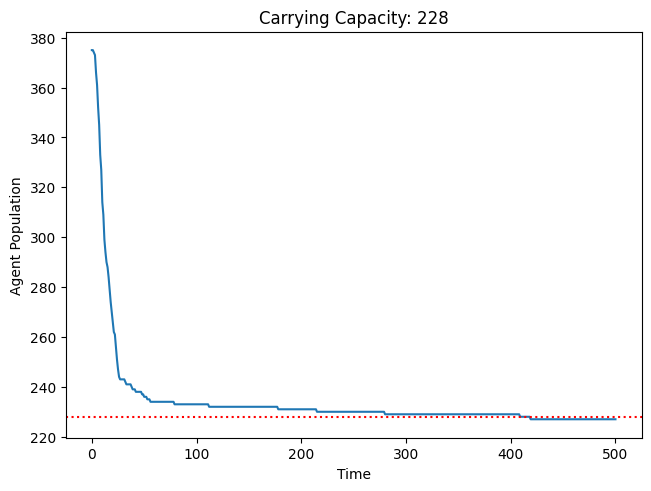

In [18]:
# Plot the agent population over time
carry_cap.plot()

As can be seen in the plot above, after 500 time steps, the agent population has stabilized at around 240 individuals. To be sure, the model can be run again...

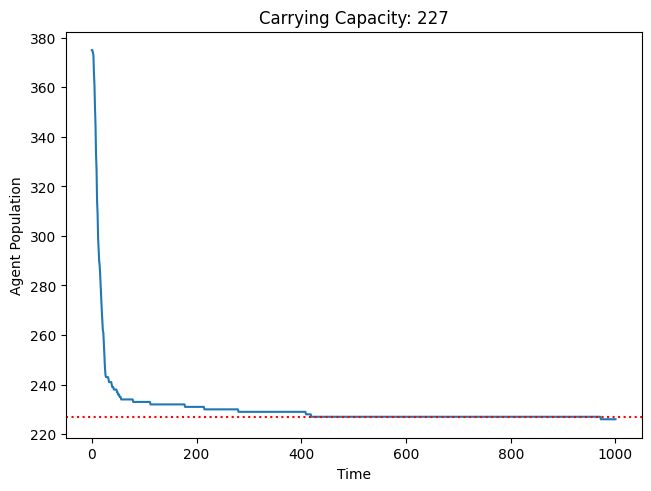

In [19]:
# Run the model for 500 more steps
carry_cap.run()

# Plot the agent population over time
carry_cap.plot()

After 1000 steps, notice that the population is still about 240. Therefore, under the default parameters, the Sugarscape model can support a population of 240 agents.

But what happens if the average agent needs more sugar to survive?

In [31]:
# Initialize a CarryingCap object with increased agent metabolism
carry_cap_2 = CarryingCap(metabolism=(2, 8))

# Run the model for 500 steps
carry_cap_2.run()

# Print the carrying capacity
print(f'Carrying capacity: {carry_cap_2.carry_cap}')

Carrying capacity: 85


After doubling the min and max possible values for agent metabolism, the carrying capacity drops significantly!

This makes sense. The Sugarscape has a limited amount of sugar and if agents require more sugar on average then more agents will be at risk of starving each time step.

What if increase the sugar growth rate?

In [32]:
# Initialize a CarryingCap object with increased agent metabolism and increased sugar growth
carry_cap_3 = CarryingCap(growth_rate=2, metabolism=(2, 8))

# Run the model for 500 steps
carry_cap_3.run()

# Print the carrying capacity
print(f'Carrying capacity: {carry_cap_3.carry_cap}')

Carrying capacity: 103


The carrying capacity increased!

Once again, this is makes sense. If sugar replenishes more quickly then more will be available to support a larger population of agents.

However, this isn't the whole story. Recall, each cell in the grid has a max sugar capacity so at a certain point increasing the growth rate will no longer increase the carrying capacity because every cell in the grid will be maxed out at every time step.

### Distribution of Sugar

Another feature of the model to explore is the distribution of sugar once the agent population reaches carrying capacity.

With this in mind, the new experiment class should be able to:

*   Generate a Sugarscape with Agents
*   Run the Sugarscape model for a specified number of time steps
*   Plot the distribution of sugar amongst the surviving agents

In [22]:
class SugarDist(Sugarscape):
    """ Setup an experimental model based on the Sugarscape model. """

    def __init__(self, **params):
        super().__init__(**params)
        self.timestep = 0

    
    def run(self, steps=500):
        # Run the model forward the specified number of steps
        for _ in range(steps):
            self.step()
        
        # Keep track of the timesteps in the models history
        self.timestep += steps

        # Get the sugar distribution throughout the population
        self.sugar = [agent.sugar for agent in self.agents]


    def hist(self):
        fig, ax = plt.subplots(layout='constrained')

        # Create a histogram of the sugar distribution
        n, bins, patches = ax.hist(sugar_dist.sugar, edgecolor='white')

        # Set the location and label for the x-ticks
        tick_locs = [patch._x0 for patch in patches]
        tick_locs.append(patches[-1]._x0+patches[-1]._width)
        tick_labs = [round(bin) for bin in bins]
        ax.set_xticks(tick_locs, tick_labs)

        # Label the histogram axes
        ax.set_xlabel('Sugar')
        ax.set_ylabel('Frequency')

        # Set the title of the histogram
        ax.set_title(f'Distribution of Sugar')

        plt.show()

In [23]:
# Initialize a SugarDist object with default parameters
sugar_dist = SugarDist()

# Run the model for 500 steps
sugar_dist.run()

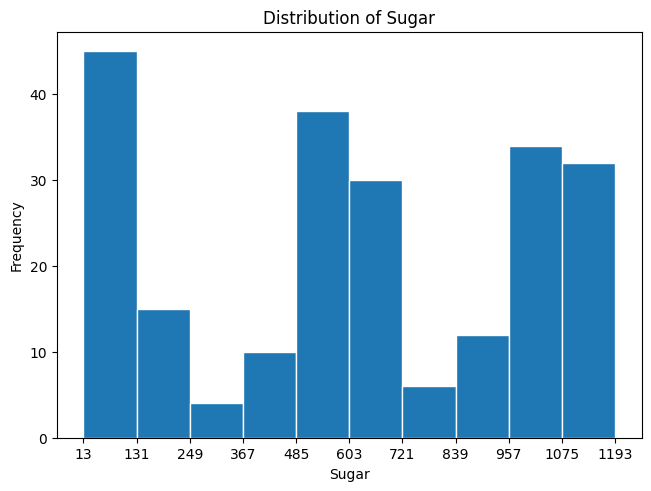

In [24]:
# Display the sugar distribution
sugar_dist.hist()

As can be seen in the histogram above, the distribution of sugar amongst agents is multimodal. This is an interesting and somewhat unexpected result! Not all of the surviving agents are "wealthy" -- instead, there are three distinct classes in the Sugarscape society.

What happens if the model is allowed to keep running?

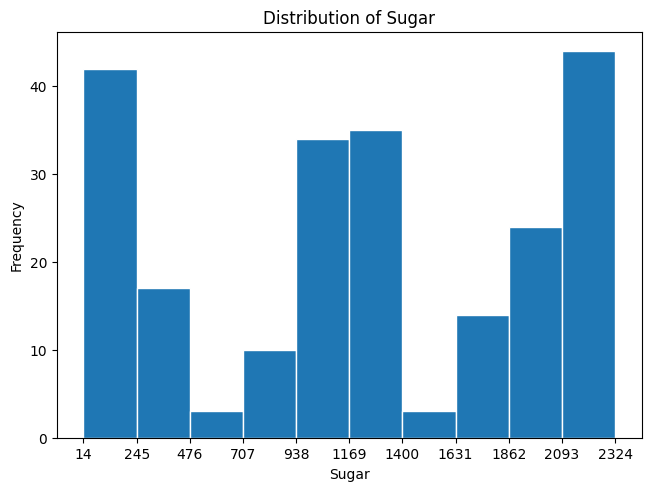

In [25]:
# Run the model for 500 more steps
sugar_dist.run()

# Display the sugar distribution
sugar_dist.hist()

And keep running?

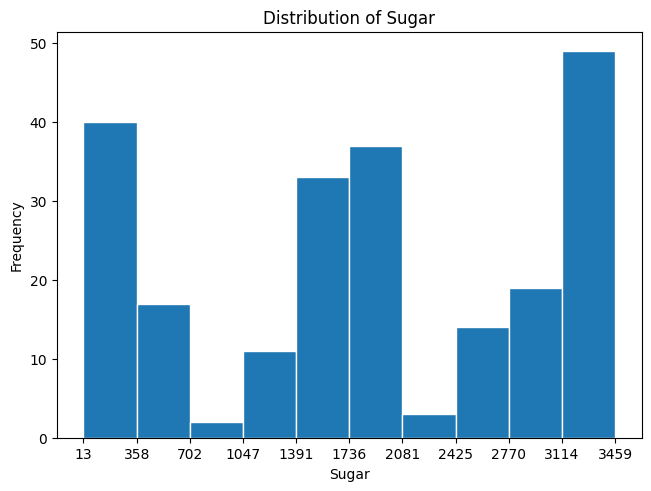

In [26]:
# Run the model for 500 more steps
sugar_dist.run()

# Display the sugar distribution
sugar_dist.hist()

Interesting!

The distribution is still multimodal but the number of agents in the uppermost bin is clearly increasing. It seems that the average net worth of agents (in terms of sugar) is growing over time, but not all agents benefit -- there are roughly the same number of agents in the lowermost bin in all three histograms.

Let's try to extract some information about the agents in each group.

In [27]:
# Extract the agents with LOW sugar stock
low_agents = [agent for agent in sugar_dist.agents if agent.sugar < 1000]

# Print the attributes of 5 random agents in the LOW group
for _ in range(5):
    agent = np.random.choice(low_agents)
    print(vars(agent))

{'position': (28, 22), 'vision': 5, 'metabolism': 3, 'sugar': 231, 'lifespan': 10000, 'age': 1500}
{'position': (35, 15), 'vision': 6, 'metabolism': 3, 'sugar': 398, 'lifespan': 10000, 'age': 1500}
{'position': (37, 24), 'vision': 4, 'metabolism': 3, 'sugar': 167, 'lifespan': 10000, 'age': 1500}
{'position': (24, 36), 'vision': 6, 'metabolism': 3, 'sugar': 355, 'lifespan': 10000, 'age': 1499}
{'position': (21, 33), 'vision': 6, 'metabolism': 3, 'sugar': 363, 'lifespan': 10000, 'age': 1500}


In [28]:
# Extract the agents with MEDIUM sugar stock
med_agents = [agent for agent in sugar_dist.agents if agent.sugar > 1000 and agent.sugar < 2500]

# Print the attributes of 5 random agents in the MEDIUM group
for _ in range(5):
    agent = np.random.choice(med_agents)
    print(vars(agent))

{'position': (47, 13), 'vision': 1, 'metabolism': 2, 'sugar': 1062, 'lifespan': 10000, 'age': 1500}
{'position': (17, 45), 'vision': 4, 'metabolism': 2, 'sugar': 1678, 'lifespan': 10000, 'age': 1499}
{'position': (22, 13), 'vision': 3, 'metabolism': 2, 'sugar': 1653, 'lifespan': 10000, 'age': 1500}
{'position': (36, 8), 'vision': 3, 'metabolism': 2, 'sugar': 1661, 'lifespan': 10000, 'age': 1500}
{'position': (38, 7), 'vision': 1, 'metabolism': 2, 'sugar': 1200, 'lifespan': 10000, 'age': 1500}


In [29]:
# Extract the agents with HIGH sugar stock
high_agents = [agent for agent in sugar_dist.agents if agent.sugar > 2500]

# Print the attributes of 5 random agents in the HIGH group
for _ in range(5):
    agent = np.random.choice(high_agents)
    print(vars(agent))

{'position': (26, 33), 'vision': 4, 'metabolism': 1, 'sugar': 3200, 'lifespan': 10000, 'age': 1499}
{'position': (19, 25), 'vision': 4, 'metabolism': 1, 'sugar': 3183, 'lifespan': 10000, 'age': 1499}
{'position': (13, 30), 'vision': 6, 'metabolism': 1, 'sugar': 3374, 'lifespan': 10000, 'age': 1500}
{'position': (34, 12), 'vision': 6, 'metabolism': 1, 'sugar': 3450, 'lifespan': 10000, 'age': 1500}
{'position': (37, 7), 'vision': 1, 'metabolism': 1, 'sugar': 2599, 'lifespan': 10000, 'age': 1498}


So interesting!

It was suspected that the vision attribute could be a key determinant of whether an agent became sugar rich. However, the output above shows that agents with high and low vision are present in all three groups.

Surprisingly, the metabolism attribute is virtually constant in all three groups! Agents in the low sugar group have the highest metabolism while agents in the high sugar group have the lowest metabolism.

It would be interesting to know how much sugar agents started with in each group. This could be another determining factor but it would require updating the Agent class to retain that information.

## Conclusions & Further Work

Although it is simplistic, Joshua Epstein and Robert Axtell's **Sugarscape** model is surprisingly powerful and with the right parameters can be used to explore interesting and unexpected societal phenomena.

Further analysis should include effects of agent lifespan (a parameter that was built into the Agent class but not yet explored) as well as the effects of birth rate (the model presented here does not spawn new agents).

The age attribute of the agents is also showing unexpected behaviour in the above outputs. All of the agents were created simultaneously but for some reason their ages are slightly different.